In [1]:
import os,sys
import pathlib
sys.path.append(os.path.abspath('./practico2'))

In [2]:
import functions_p2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats

In [3]:
path_table = os.path.abspath('./practico2/table3.csv') #Path a la tabla descargada de Casjobs
df = functions_p2.process_table(path_table=path_table) #Funcion que procesa la tabla

<Axes: xlabel='petroMag_ur', ylabel='Count'>

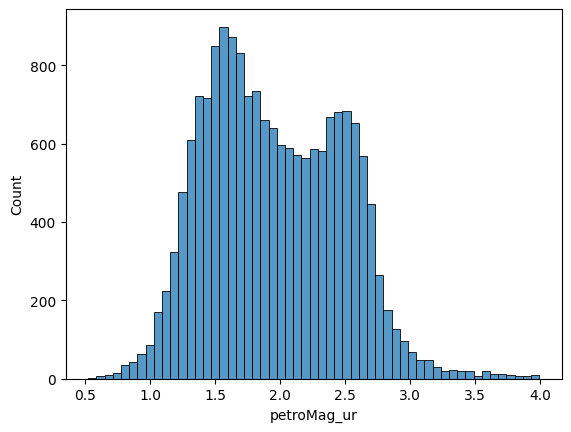

In [5]:
sns.histplot(data=df[(df['petroMag_ur'] < 4) &(df['petroMag_ur']>0.5)],x='petroMag_ur')


In [77]:
list(df)

['ra',
 'dec',
 'redshift',
 'fracDeV_r',
 'velDisp',
 'c_index',
 'petroMag_ur',
 'modelMag_ur',
 'petroMag_gr',
 'modelMag_gr',
 'petroMag_u',
 'petroMag_g',
 'petroMag_r',
 'petroMag_i',
 'petroMag_z',
 'modelMag_u',
 'modelMag_g',
 'modelMag_r',
 'modelMag_i',
 'modelMag_z',
 'petroR50_r',
 'petroR90_r',
 'mu_50_r']

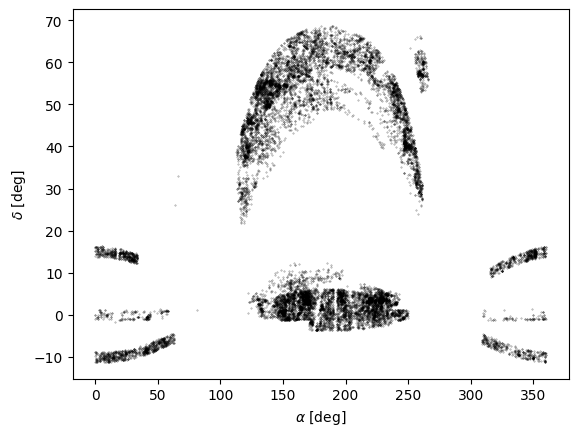

In [78]:
plt.scatter(df['ra'],df['dec'],s=0.1,c="black",alpha=0.5)
plt.xlabel(r"$\alpha$ [deg]")
plt.ylabel(r"$\delta$ [deg]")
# sns.scatterplot(data=df,x='ra',y='dec',s=0.9,c='black')
plt.savefig('delta.jpg')

# Practico

## Magnitudes Model y Petro

Fuente 1: <a href="https://skyserver.sdss.org/dr7/en/help/docs/algorithm.asp?key=mag_petro">Petro Mag</a>

Fuente 2: <a href="https://www.sdss4.org/dr17/algorithms/magnitudes/">Todas las magnitudes</a>

- Magnitudes petrosianas: Para la fotometria de galaxias medir el flujo de las mismas es mas dificil que hacerlo con estrellas ya que las galaxias no poseen el mismo perfil superficial de brillo asi como tampoco tienen bordes bien definidos.

- Para superar la dificultad anterior quisieramos medir una fraccion constante de su luz total independientemente de la posicion y distancia del objeto.

- Para realizar esto el SDSS ha adoptado una version modificada de las magnitudes petrosianas , de manera que se mide los flujos provenientes de las galaxias con una apertura circular cuyo radio esta definido por la forma del perfil de luz promediado azimutalmente.

- Hay varias definiciones:

- Petrosian Ratio: $R_{P}(r)$ a radio $r$

## Parte 4
Se pide realizar los graficos:

a) $M_{r}$ vs $z $ , aca $M_{r}$ hace referencia a la maginitud Petrosiana (segun aclara una pregunta mas adelante)

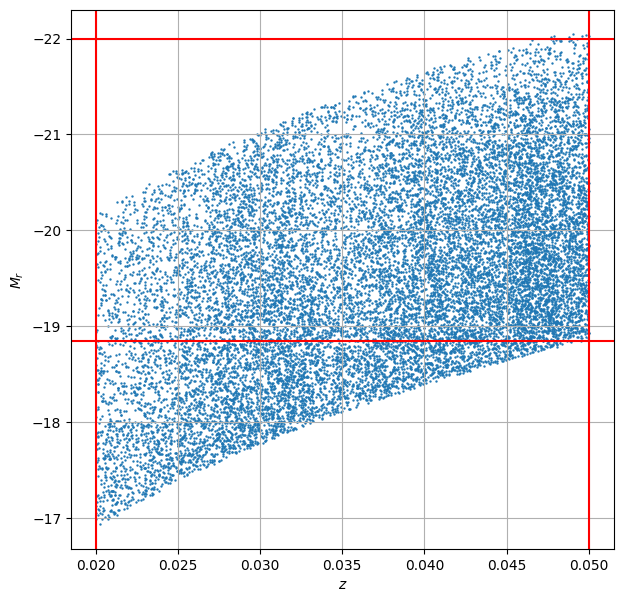

In [81]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.scatter(df['redshift'],df['petroMag_r'],s=0.5)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$M_{r}$')
plt.gca().invert_yaxis()
ax.grid()
ax.axvline(x=0.05,c="red")
ax.axvline(x=0.02,c="red")
ax.axhline(y=-18.85,c="red")
ax.axhline(y=-22,c="red")
plt.savefig("volsample.jpg")

Esta figura muestra que para redshifts mas altos solamente se perciben las fuentes luminosas mas fuertes, mientras que las mas debiles se han perdido. Estudiar galaxias con esta muestra puede introducir sesgos a favor de las fuentes luminosas mas fuertes, por lo cual una opcion para tener la muestra mas completa posible es remover elementos correspondientes a fuentes luminosas por debajo de -19.

b) En una sola figura, pero en distintos paneles, distribucion de los colores (u−r)
y (g − r). Realizar un ajuste bimodal de los colores.

In [8]:
df = df[df['petroMag_r']<-18.85]
df.shape
# print(13303/20000)

(13303, 23)

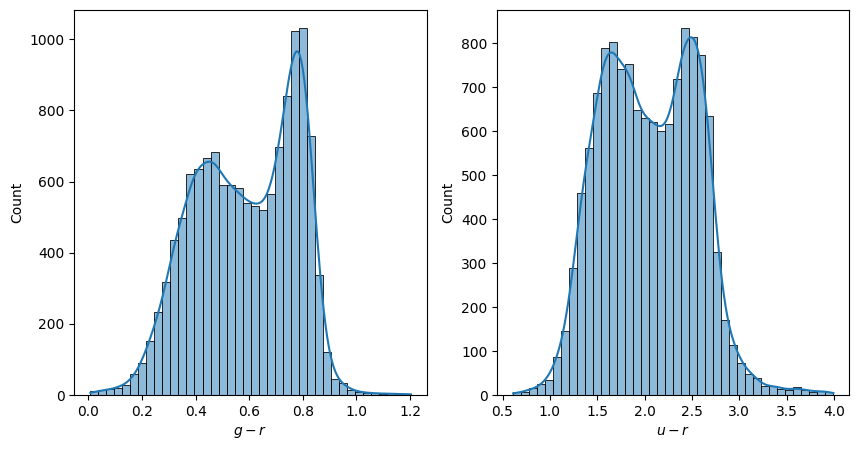

In [9]:
df2 = df[(df['petroMag_gr']>0) & (df['petroMag_gr']<1.25)]
df3 = df[(df['petroMag_ur'] < 4) &(df['petroMag_ur']>0.5)]

# Build figure
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.histplot(df2['petroMag_gr'], ax=ax[0],kde=True, bins=40,)
sns.histplot(df3['petroMag_ur'], ax=ax[1],kde=True, bins=40,)
ax[0].set(xlabel=r"$g-r$")
ax[1].set(xlabel=r"$u-r$")
plt.savefig('bimodal_gr_ur.jpg')

c) Distribucion normalizada de C y fracDeVr. Para que sirven estos parametros,
que informacion nos dan? Hay algura relacion entre ellos, de ser asi, graficarla.
Aunque no tenemos la relacion bulge-to-disk entre los parametros, que puede
decir al respecto?

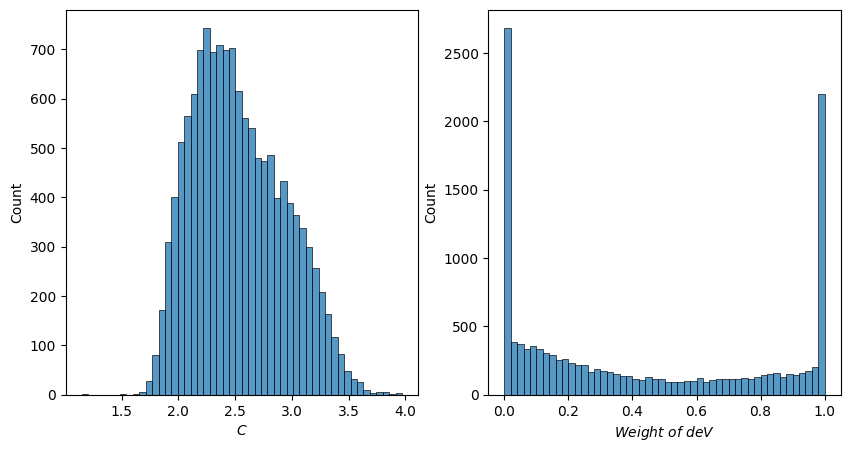

In [10]:
df22 = df2[df2['c_index']<4]
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.histplot(df22['c_index'], ax=ax[0],kde=False,bins=50)
ax[0].set(xlabel=r"$C$")
ax[1].set(xlabel=r"$Weight$ $of$ $deV$")
sns.histplot(df3['fracDeV_r'], ax=ax[1],kde=False,bins=50)
plt.savefig('c_indexx.jpg')

- El grafico del indice de concentracion muestra una especie de bimodalidad. Sin embargo no hay tal. Hay un gran cantidad de galaxias con un indice de concentracion de 2.2 o 2.1 , que serian mas galaxias espirales.

- Despues hay una menor concentracion de elementos que tienen centro en masomenos 3.0, esas son galaxias elipticas. Y diriamos que hay menor cantidad.

- Si examinamos el paper: *The Luminosity Function of Galaxies in SDSS Commissioning Data* en el apartado 4.5 *Dependence of Luminosity on Morphology* se indica que el indice de concentracion es grancde para las de Vaucouleurs puras, c=3.3, y bajo para las exponenciales puras, c=2.3. Recuerde que el perfil exponencial pertenece mas que nada a las espirales y el de V a las galaxias elipticas.

- *It has been shown to correlate well with visual morphological classification for bright galaxies*

### Sobre fracdev
- Definicion: fracdev is a photometric parameter providing the weight of a de Vaucouleurs component
in the best composite exponential + de Vaucouleurs models.

- Primero hay que entender que el perfil de de V hace referencia a la distribucion de luz de una galaxia eliptica. De wikipedia tenemos: La ley de De Vaucouleurs (también denominada perfil de De Vaucouleurs) describe cómo la brillantez de la superficie I de una galaxia elíptica varía en función de la distancia aparente R desde el centro.

- Este perfil se expresa como la formula: $I(r)=exp(-k (\frac{r}{r_{e}})^{1/4})$ donde $r_{e}$ es un radio conteniendo la mitad de la luz de la galaxia.

- entre mas cerca e 1 sea fracdev, mas eliptica es la galaxia. O mas bien, mas componente de Vauculerurs tiene la galaxia. Entre mas cerca a 0, menos tiene de este componente y por lo tanto seria menos eliptica.

- Con lo dos diagramas anteriores, yo diria que hay una mayor poblacion de galaxias no elipticas.

,c_index,fracDeV_r
c_index,1.000000,0.817831
fracDeV_r,0.817831,1.000000


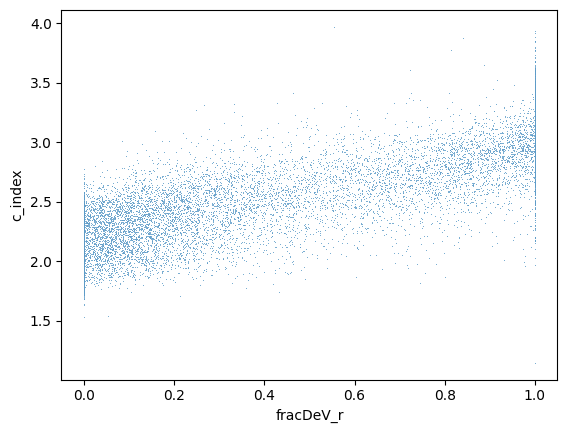

In [11]:
df33 = df3[df3['c_index']<4]
sns.scatterplot(data=df33,y='c_index',x='fracDeV_r',s=0.5)
df33[['c_index','fracDeV_r']].corr()

0.8547567416261986 2.167229588474118 0.8178305306772752 0.0052416350926602125


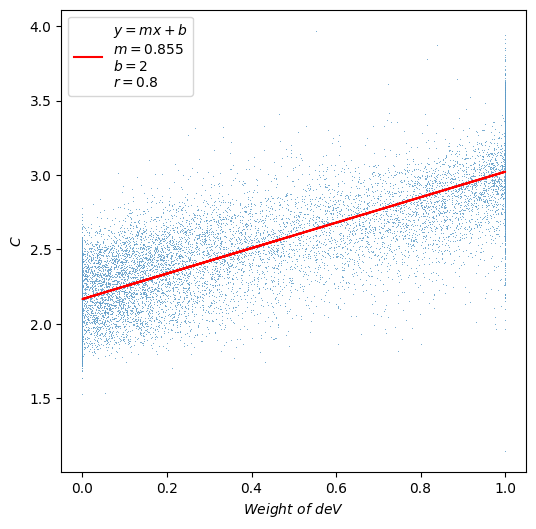

In [23]:
#hagamos un linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df33['fracDeV_r'],df33['c_index'])
print(slope,intercept,r_value,std_err)
# Generate the fitted line
y_fit = slope * df33['fracDeV_r'] + intercept
fig,ax = plt.subplots(1,1,figsize=(6,6))
sns.scatterplot(data=df33,y='c_index',x='fracDeV_r',s=0.5,ax=ax)
ax.plot(df33['fracDeV_r'], y_fit, color='red',
        label = r"$y = mx+b$""\n" r"$m=0.855$""\n" r"$b=2$" "\n"r"$r=0.8$"
        )
ax.set_xlabel(r"$Weight$ $of$ $deV$")
ax.set_ylabel(r"$C$")
plt.legend()
plt.savefig('linear.jpg')

d) Considerando el  ́ındice de concentraci ́on para separar a las galaxias en de tipo
temprano y de tipo tardio, y el color u − r (valor constante) para clasificar en
rojas y azules. Hay algun valor constante que haga una discriminacion de morfologia para las galaxias u-r?

Para poder estudiar esto, vamos a hacer un ajuste bimodal de la magnitud u-r para las magnitudes petro.

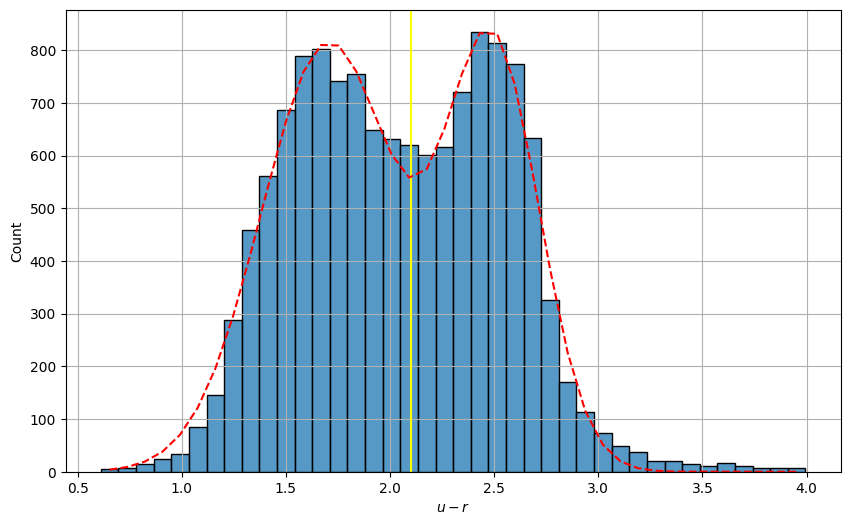

In [25]:
# Defino la doble gaussiana:
def double_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp((- (x - mu1)**2) / (2 * sigma1**2)) +
            A2 * np.exp((- (x - mu2)**2)/ (2 * sigma2**2)))

# Defino el initial guess
initial_guess = [850, 1.6, 0.4, 690, 2.5, 0.2] # Usar grafico derecho de el histograma u-r
# Como x e y necesito el valor medio de los bins
# 1) Haga el histograma en numpy
counts,bins = np.histogram(df3['petroMag_ur'],bins=40)
# 2) Get the mids of bins
bin_mids = (bins[:-1] + bins[1:]) / 2

#Ahora haremos el ajuste
popt, pcov = curve_fit(double_gaussian, bin_mids, counts, p0=initial_guess)

# Extracting the optimal parameters
A1, mu1, sigma1, A2, mu2, sigma2 = popt

# Plot the data and the fit
fig, ax = plt.subplots(1,1,figsize=(10,6))
# plt.figure(figsize=(10, 6))
# ax.plot(bin_mids, counts, 'b-', label='Data')
#plt.plot(bin_mids, counts, 'b-', label='Data')
sns.histplot(df3['petroMag_ur'],bins=40)
ax.set(xlabel=r"$u-r$")
ax.axvline(x=2.1,c="yellow")
plt.plot(bin_mids, double_gaussian(bin_mids, *popt), 'r--', label='Fit: double Gaussian')
plt.grid()
plt.savefig('bimodal.jpg')

In [26]:
#examinamos los parametros:
A1, mu1, sigma1, A2, mu2, sigma2
# La parte media la tomaremos como la suma pesada
# ur_index = (A1*mu1 + A2*mu2)/(A1+A2)
# ur_index



(814.2076642035886,
 1.7058796755248737,
 0.322475139066512,
 799.1897301307245,
 2.494731930136273,
 0.22484058978678093)

In [27]:
# Valor de corte
corte = (A1*mu1+A2*mu2)/(A1+A2)
corte

2.096634379040444

# Grafico Diagrama color magnitud

In [13]:
#restrinjo un poco los valores para que el grafico quede mejor

In [28]:
# Defino un par de funciones que me ayudaran a hacer mis ajustes
def double_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp((- (x - mu1)**2) / (2 * sigma1**2)) +
            A2 * np.exp((- (x - mu2)**2)/ (2 * sigma2**2)))

def fitter(x,initial_guess,bins):
	counts,bins = np.histogram(x,bins=bins)
	bin_mids = (bins[:-1] + bins[1:]) / 2
	popt, pcov = curve_fit(double_gaussian, bin_mids, counts, p0=initial_guess)
	# Extracting the optimal parameters
	A1, mu1, sigma1, A2, mu2, sigma2 = popt
	# return {'A1':A1,'mu1':mu1,'sigma1':sigma1,'A2':A2,'mu2':mu2,'sigma2':sigma2}
	return {'popt':popt,'bin_mids':bin_mids,'counts':counts}

In [29]:
# Busco los quintiles
decimals = 1
quantiles = [
    round(df3['petroMag_r'].quantile(q=0.2),decimals),
    round(df3['petroMag_r'].quantile(q=0.4),decimals),
    round(df3['petroMag_r'].quantile(q=0.6),decimals),
    round(df3['petroMag_r'].quantile(q=0.8),decimals)
    ]
quantiles

[-20.7, -20.1, -19.7, -19.2]

In [30]:
df3 = df3[df3['petroMag_ur']<4]

In [31]:
df3_r = df3[['petroMag_r','petroMag_ur']].round(decimals)
df_0 = df3_r[df3_r['petroMag_r']==quantiles[0]]
df_1 = df3_r[df3_r['petroMag_r']==quantiles[1]]
df_2 = df3_r[df3_r['petroMag_r']==quantiles[2]]
df_3 = df3_r[df3_r['petroMag_r']==quantiles[3]]

<Axes: xlabel='petroMag_ur', ylabel='Count'>

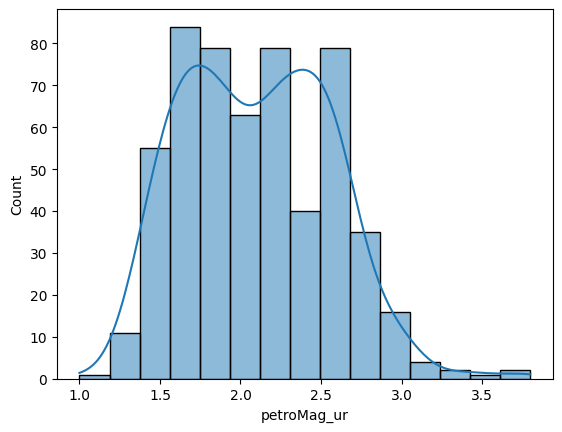

In [32]:
sns.histplot(df_1['petroMag_ur'],bins=15,kde=True)

In [33]:
fit_0 = fitter(x=df_0['petroMag_ur'],initial_guess=[25,1.9,0.4,42,2.7,0.2],bins=15)
fit_1 = fitter(x=df_1['petroMag_ur'],initial_guess=[36,1.7,0.4,33,2.5,0.2],bins=15)
fit_2 = fitter(x=df_2['petroMag_ur'],initial_guess=[90,1.7,0.4,40,2.5,0.2],bins=15)
fit_3 = fitter(x=df_3['petroMag_ur'],initial_guess=[70,1.5,0.4,20,2.5,0.1],bins=15)

In [34]:
a10, mu10, sigma10, a20, mu20, sigma20 = fit_0#,fit_1,fit_2,fit_3

ValueError: not enough values to unpack (expected 6, got 3)

In [35]:
##A1, mu1, sigma1, A2, mu2, sigma2 = popt
fits = [fit_0,fit_1,fit_2,fit_3]
x = [quantiles[i] for i in range(4)]
y1 = [f['popt'][1] for f in fits]
y4 = [f['popt'][4] for f in fits]

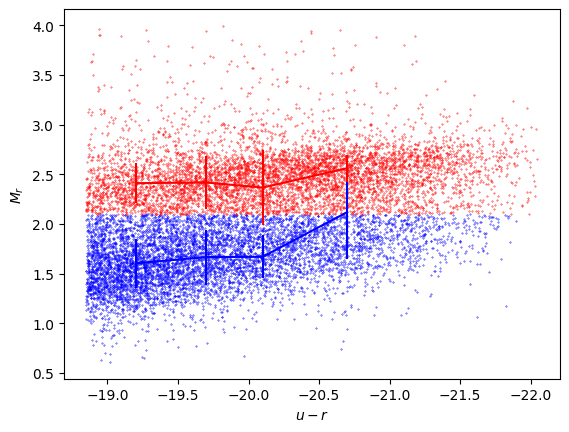

In [36]:
fig,ax = plt.subplots()
ax.scatter(df3[df3['petroMag_ur']<2.1]['petroMag_r'],df3[df3['petroMag_ur']<2.1]['petroMag_ur'],s=0.1,c='blue')
ax.scatter(df3[df3['petroMag_ur']>2.1]['petroMag_r'],df3[df3['petroMag_ur']>2.1]['petroMag_ur'],s=0.1,c='red')
#quartil 0
# ax.scatter(quantiles[0],fit_0['popt'][1],c='blue')
ax.errorbar(quantiles[0],fit_0['popt'][1],yerr=fit_0['popt'][2],c='blue')
# ax.scatter(quantiles[0],fit_0['popt'][4],c='blue')
ax.errorbar(quantiles[0],fit_0['popt'][4],yerr=fit_0['popt'][5],c='red')
#quartil 1
# ax.scatter(quantiles[1],fit_1['popt'][1],c='blue')
ax.errorbar(quantiles[1],fit_1['popt'][1],yerr=fit_1['popt'][2],c='blue')
# ax.scatter(quantiles[1],fit_1['popt'][4],c='blue')
ax.errorbar(quantiles[1],fit_1['popt'][4],yerr=fit_1['popt'][5],c='red')
#quartil 2
# ax.scatter(quantiles[2],fit_2['popt'][1],c='blue')
ax.errorbar(quantiles[2],fit_2['popt'][1],yerr=fit_2['popt'][2],c='blue')
# ax.scatter(quantiles[2],fit_2['popt'][4],c='blue')
ax.errorbar(quantiles[2],fit_2['popt'][4],yerr=fit_2['popt'][5],c='red')
#quartil 3
# ax.scatter(quantiles[3],fit_3['popt'][1],c='blue')
ax.errorbar(quantiles[3],fit_3['popt'][1],yerr=fit_3['popt'][2],c='blue')
# ax.scatter(quantiles[3],fit_3['popt'][4],c='blue')
ax.errorbar(quantiles[3],fit_3['popt'][4],yerr=fit_3['popt'][5],c='red')
ax.plot(x,y1,c='blue')
ax.plot(x,y4,c='red')
ax.set_xlabel(r'$u-r$')
ax.set_ylabel(r'$M_{r}$')
plt.gca().invert_xaxis()
plt.savefig('diag_col_mag.jpg')

# Correlacion entre C y u-r

/tmp/ipykernel_203156/3738198944.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = df3[(df['c_index'] < 4) & (df['modelMag_ur']<4)]


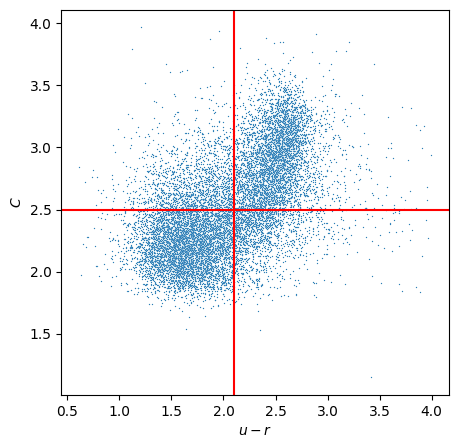

In [57]:
# Tambien examinamos una hipotetica correlacion entre u-r y C:
df4 = df3[(df['c_index'] < 4) & (df['modelMag_ur']<4)]
fig,ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(data=df4,y='c_index',x='petroMag_ur',s=0.9,ax=ax)
ax.axhline(y=2.5,c='red')
ax.axvline(x=2.1,c='red')
ax.set_xlabel(r"$u-r$")
ax.set_ylabel(r"$C$")
plt.savefig('c_ur.jpg')


In [58]:

df4[(df4['c_index']>2.5)&(df4['modelMag_ur']>2.1)].shape[0]/df4.shape[0]
# df4[(df4['c_index']<2.5)&(df4['modelMag_ur']<2.1)].shape[0]/df4.shape[0]
# df4[(df4['c_index']>2.5)&(df4['modelMag_ur']<2.1)].shape[0]/df4.shape[0]
# df4[(df4['c_index']<2.5)&(df4['modelMag_ur']>2.1)].shape[0]/df4.shape[0]

0.3679531986020362

In [59]:
df4[['c_index','petroMag_ur']].corr()

,c_index,petroMag_ur
c_index,1.000000,0.540606
petroMag_ur,0.540606,1.000000


In [60]:
df4['log_r_50'] = np.log10(df4['petroR50_r'])
df4 = df4[df4['log_r_50']<4.6]

/tmp/ipykernel_203156/269740080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['log_r_50'] = np.log10(df4['petroR50_r'])


In [61]:
df4[['log_r_50','petroMag_ur']].corr()

,log_r_50,petroMag_ur
log_r_50,1.000000,-0.151072
petroMag_ur,-0.151072,1.000000


In [63]:
# df4 = df4[df4['c_index']<2.5] # Estas son las galaxias late type (espirales)
# df4 = df4[df4['c_index']>2.5] # Estas son las galaxias early type (elipticas)
# df4 = df4[df4['petroMag_ur'] < 1.9] # Galaxias de la nube azul
# df4 = df4[df4['petroMag_ur'] > 1.9] # Galaxias de la secuencia roja

# df4 = df4[(df4['petroMag_ur']<2.45+0.26)&(df4['petroMag_ur']>2.45-0.26)] # Nube azul
# df4 = df4[(df4['petroMag_ur']<1.61+0.31)&(df4['petroMag_ur']>1.61-0.31)] # secuencia roja

# Galaxias secuencia roja y early type
# df5 = df4[(df4['c_index']>2.5) & (df4['petroMag_ur'] > 2.1)]
# df4['class'] = (df4['c_index']>2.5).map({True: 'c>2.5', False: 'c<2.5'})

# Galaxias nube azul y late type
df6 = df4[(df4['c_index']<2.5) & (df4['petroMag_ur'] < 2.1)]
# df4['class'] = df4[(df4['c_index']<2.5) ]
df4['class'] = (df4['petroMag_ur']>2.1).map({True: 'u-r>2.1', False: 'u-r<2.1'})



In [71]:
# Selecciona aca que tipo de corte queres en las galaxias
df5 = df4[(df4['petroMag_ur']>2.1)&(df4['c_index']>2.5)]
df6 = df4[(df4['petroMag_ur']<2.1)&(df4['c_index']<2.5)]
# df5 = df4[(df4['c_index']>2.5)]
# df6 = df4[(df4['c_index']<2.5)]
# df5 = df4[(df4['petroMag_ur']>2.1)]
# df6 = df4[(df4['petroMag_ur']<2.1)]

slope, intercept, r_value, p_value, std_err = stats.linregress(df5['petroMag_r'],df5['log_r_50'])
slope6, intercept6, r_value6, p_value6, std_err6 = stats.linregress(df6['petroMag_r'],df6['log_r_50'])
# Generate the fitted line
y_fit = slope * df5['petroMag_r'] + intercept
y_fit6 = slope6 * df6['petroMag_r'] + intercept6



In [68]:
print(slope, intercept, r_value, p_value, std_err)
print(slope6, intercept6, r_value6, p_value6, std_err6)

-0.10968152528707245 1.714669376323687 -0.45431301853145517 2.413435778413126e-309 0.0027503047007555897
-0.11624283070792248 1.7158748377499986 -0.46007897923317154 0.0 0.0026741964196154116


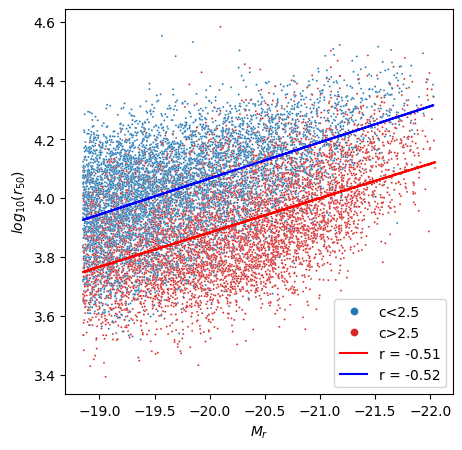

In [53]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(data=df4,x='petroMag_r',y='log_r_50',ax=ax,hue='class',s=2.0,
                palette={
        'c<2.5':'tab:blue',
        'c>2.5':'tab:red'
             })
ax.plot(df5['petroMag_r'], y_fit, color='red', label='r = {:.2f}'.format(r_value))
ax.plot(df6['petroMag_r'], y_fit6, color='blue', label='r = {:.2f}'.format(r_value6))
ax.legend(markerscale=4.)
ax.invert_xaxis()
ax.set_xlabel(r"$M_{r}$")
ax.set_ylabel(r"$log_{10}(r_{50})$")
plt.savefig('adjust_c.jpg')

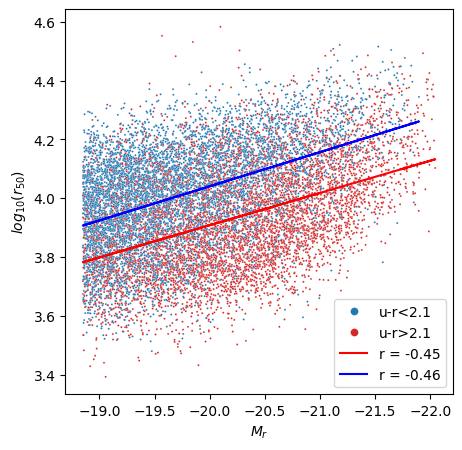

In [69]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(data=df4,x='petroMag_r',y='log_r_50',ax=ax,hue='class',s=2.0,
                palette={
        'u-r>2.1':'tab:red',
        'u-r<2.1':'tab:blue'
             })
ax.plot(df5['petroMag_r'], y_fit, color='red', label='r = {:.2f}'.format(r_value))
ax.plot(df6['petroMag_r'], y_fit6, color='blue', label='r = {:.2f}'.format(r_value6))
ax.legend(markerscale=4.)
ax.invert_xaxis()
ax.set_xlabel(r"$M_{r}$")
ax.set_ylabel(r"$log_{10}(r_{50})$")
plt.savefig('adjust_ur.jpg')



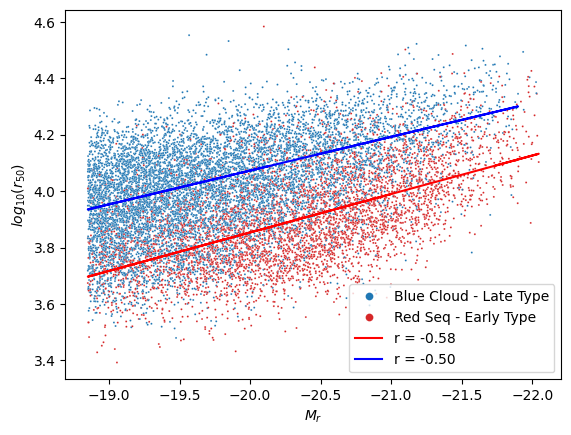

In [73]:
# Galaxias secuencia roja y early type
df4['classification'] = ((df4['c_index']>2.5) & (df4['petroMag_ur'] > 2.1)).map({True: 'Red Seq - Early Type', False: 'Blue Cloud - Late Type'})
ax = sns.scatterplot(
    data=df4,
    x='petroMag_r',
    y='log_r_50',
    s=2.0,
    hue='classification',
    palette={
        'Red Seq - Early Type':'tab:red',
        'Blue Cloud - Late Type':'tab:blue'
             }
    )
ax.plot(df5['petroMag_r'], y_fit, color='red', label='r = {:.2f}'.format(r_value))
ax.plot(df6['petroMag_r'], y_fit6, color='blue', label='r = {:.2f}'.format(r_value6))
ax.legend(markerscale=4.)
ax.invert_xaxis()
ax.set_xlabel(r"$M_{r}$")
ax.set_ylabel(r"$log_{10}(r_{50})$")
plt.savefig('final.jpg')